In [3]:
########################################################################################################################
#                                                          IMPORT                                                      #
########################################################################################################################
import torch
import sys
sys.path.append('..')
import os
import json
import time
import numpy as np
import argparse

from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler
from umap.umap_ import find_ab_params

from singleVis.custom_weighted_random_sampler import CustomWeightedRandomSampler
from singleVis.SingleVisualizationModel import VisModel
from singleVis.losses import UmapLoss, ReconstructionLoss, DVILoss, DummyTemporalLoss
from singleVis.edge_dataset import VisDataHandler
from singleVis.trainer import VISTrainer
from singleVis.eval.evaluator import Evaluator
from singleVis.data import NormalDataProvider
from trustVis.sampeling import CriticalSampling
from singleVis.spatial_edge_constructor import Trustvis_SpatialEdgeConstructor, TrustvisTemporalSpatialEdgeConstructor

from singleVis.utils import _construct_fuzzy_complex

from singleVis.projector import VISProjector

import torch.nn.functional as F
########################################################################################################################
#                                                      PARAMETERS                                                   #
########################################################################################################################
"""This serve as an example of DeepVisualInsight implementation in pytorch."""
VIS_METHOD = "DVI" #

########################################################################################################################
#                                                     LOAD PARAMETERS                                                  #
########################################################################################################################


parser = argparse.ArgumentParser(description='Process hyperparameters...')

# get workspace dir
current_path = os.getcwd()

parent_path = os.path.dirname(current_path)

new_path = os.path.join(parent_path, 'training_dynamic')


CONTENT_PATH = '/home/yifan/0ExpMinist/Default/02'
sys.path.append(CONTENT_PATH)
with open(os.path.join(CONTENT_PATH, "config.json"), "r") as f:
    config = json.load(f)
config = config[VIS_METHOD]

CLASSES = config["CLASSES"]
DATASET = config["DATASET"]
PREPROCESS = config["VISUALIZATION"]["PREPROCESS"]
GPU_ID = config["GPU"]
EPOCH_START = config["EPOCH_START"]
EPOCH_END = config["EPOCH_END"]
EPOCH_PERIOD = config["EPOCH_PERIOD"]

EPOCH_START = 3
EPOCH_END = 3
epoch = EPOCH_START
# EPOCH_START = 1
# EPOCH_END = 50
EPOCH_PERIOD = 1

# Training parameter (subject model)
TRAINING_PARAMETER = config["TRAINING"]
NET = TRAINING_PARAMETER["NET"]
LEN = TRAINING_PARAMETER["train_num"]

# Training parameter (visualization model)
VISUALIZATION_PARAMETER = config["VISUALIZATION"]
LAMBDA1 = 1
LAMBDA2 = VISUALIZATION_PARAMETER["LAMBDA2"]
B_N_EPOCHS = 0
L_BOUND = VISUALIZATION_PARAMETER["BOUNDARY"]["L_BOUND"]
ENCODER_DIMS = VISUALIZATION_PARAMETER["ENCODER_DIMS"]
DECODER_DIMS = VISUALIZATION_PARAMETER["DECODER_DIMS"]
S_N_EPOCHS = VISUALIZATION_PARAMETER["S_N_EPOCHS"]
N_NEIGHBORS = VISUALIZATION_PARAMETER["N_NEIGHBORS"]
PATIENT = VISUALIZATION_PARAMETER["PATIENT"]
MAX_EPOCH = VISUALIZATION_PARAMETER["MAX_EPOCH"]
VIS_MODEL_NAME = 'trustvis_tempo_fine_tune_conf' ### saved_as VIS_MODEL_NAME.pth
# Define hyperparameters
GPU_ID = 0
DEVICE = torch.device("cuda:{}".format(GPU_ID) if torch.cuda.is_available() else "cpu")
print("device", DEVICE)           

import Model.model as subject_model
net = eval("subject_model.{}()".format(NET))
data_provider = NormalDataProvider(CONTENT_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, device=DEVICE, epoch_name='Epoch',classes=CLASSES,verbose=1)
# Define visualization models
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
# Define Losses
negative_sample_rate = 5
min_dist = .1
_a, _b = find_ab_params(1.0, min_dist)


device cuda:0
Finish initialization...


100%|██████████| 300/300 [00:00<00:00, 5868.59it/s]


Successfully load the DVI visualization model for iteration 3
Successfully load the DVI visualization model for iteration 3


100%|██████████| 300/300 [00:00<00:00, 6121.05it/s]


conf_error number: 714
Successfully load the DVI visualization model for iteration 3
Computing decision regions ...
Successfully load the DVI visualization model for iteration 3
Successfully load the DVI visualization model for iteration 3
grid_samples (160000, 512)


100%|██████████| 800/800 [00:00<00:00, 3201.99it/s]


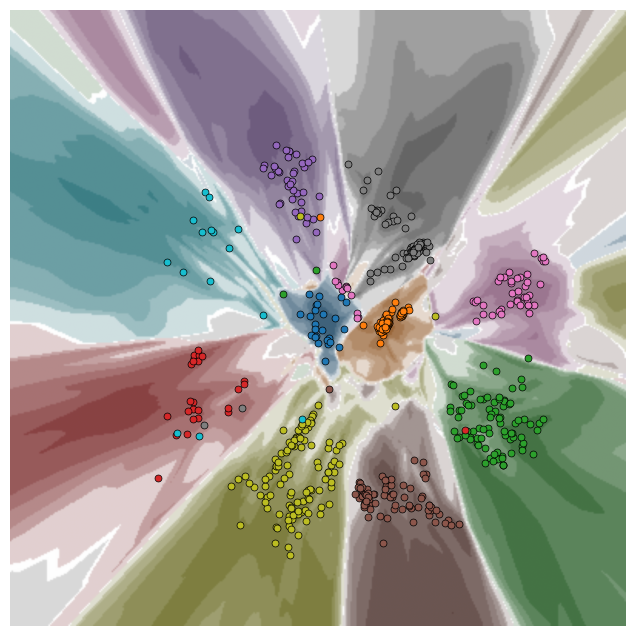

In [4]:
projector = VISProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name=VIS_MODEL_NAME, device=DEVICE)
path = "/home/yifan/dataset/case_study_mnist_backdoor/clean_label.json"
with open(path, "r") as f:
    clean_label = json.load(f)
    
with open("/home/yifan/dataset/case_study_mnist_backdoor/noisy_label.json", "r") as f:
    noise_label = json.load(f)

noise_indicates = []
for i in range(len(clean_label)):
    if clean_label[i] != noise_label[i]:
        noise_indicates.append(i)

save_dir = os.path.join(data_provider.content_path, VIS_MODEL_NAME)
train_data = data_provider.train_representation(epoch)
labels = data_provider.train_labels(epoch)

train_data = train_data.reshape(train_data.shape[0],train_data.shape[1])

pred = data_provider.get_pred(epoch, train_data)
new_pred_Res = pred.argmax(axis=1)

emb = projector.batch_project(epoch,train_data)
indicates = noise_indicates

sort_preds = np.sort(pred, axis=1)
diff = (sort_preds[:, -1] - sort_preds[:, -2]) / (sort_preds[:, -1] - sort_preds[:, 0])

inv = projector.batch_inverse(epoch, emb)
inv_pred = data_provider.get_pred(epoch, inv)
inv_sort_preds = np.sort(inv_pred, axis=1)
inv_diff = (inv_sort_preds[:, -1] - inv_sort_preds[:, -2]) / (inv_sort_preds[:, -1] - inv_sort_preds[:, 0])
conf_error = []
for i in range(len(diff)):
    if abs(diff[i] - inv_diff[i]) > 0.3:
        conf_error.append(i)
print("conf_error number:", len(conf_error))
# from singleVis.eval.evaluate import *
# val = evaluate_proj_nn_perseverance_knn(train_data, emb, n_neighbors=15, metric="euclidean")
from singleVis.visualizer import visualizer
now = time.strftime("%Y-%m-%d-%H_%M_%S", time.localtime(time.time())) 
vis = visualizer(data_provider, projector, 400, "tab10")
vis.savefig_custom(epoch, path=os.path.join(save_dir, "{}_{}_{}_{}.png".format(DATASET, epoch, VIS_METHOD,now)),
            pred=new_pred_Res[conf_error],
            train_labels=new_pred_Res[conf_error], 
            embedding=emb[conf_error])

In [51]:
#### next we will retrain the model that freeze decoder: inv_grid is fixed. 

In [5]:
spatial_cons = Trustvis_SpatialEdgeConstructor(data_provider, epoch, S_N_EPOCHS, B_N_EPOCHS, N_NEIGHBORS, net)
edge_to, edge_from, probs, pred_probs, feature_vectors, attention = spatial_cons.construct()

train data (60000, 512)


100%|██████████| 300/300 [00:00<00:00, 6071.05it/s]

Sun Apr 21 14:20:30 2024 Building RP forest with 17 trees


Sun Apr 21 14:20:31 2024 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Gradients calculation: 47.00 seconds	softmax with temperature: 0.00 seconds


In [20]:
from sklearn.neighbors import NearestNeighbors
def _get_confidence_error_pairs(data_provider, epoch, projector, vis,threshold=0.3,resolution=200,k_neibour=15,max_refine=5000):
    train_data = data_provider.train_representation(epoch)
    train_data = train_data.reshape(train_data.shape[0],train_data.shape[1])
    pred = data_provider.get_pred(epoch, train_data)
    pred_res = pred.argmax(axis=1)
    sort_preds = np.sort(pred, axis=1)
    diff = (sort_preds[:, -1] - sort_preds[:, -2]) / (sort_preds[:, -1] - sort_preds[:, 0])
    # print("get org pred")
    emb = projector.batch_project(epoch,train_data)
    inv = projector.batch_inverse(epoch, emb)
    inv_pred = data_provider.get_pred(epoch, inv)
    inv_pred_res = inv_pred.argmax(axis=1)
    inv_sort_preds = np.sort(inv_pred, axis=1)
    inv_diff = (inv_sort_preds[:, -1] - inv_sort_preds[:, -2]) / (inv_sort_preds[:, -1] - inv_sort_preds[:, 0])
    # print("get inv pred")
    conf_error = []
    diff_values=[]
    for i in range(len(diff)):
        abs_diff = abs(diff[i] - inv_diff[i])
        if abs_diff > threshold or pred_res[i]!=inv_pred_res[i]:
            conf_error.append(i)
            diff_values.append((abs_diff, pred_res[i] != inv_pred_res[i]))
    print("real conf_error number:",len(conf_error),resolution)
    # Combine indices with their respective differences and whether prediction differed
    indexed_diff = list(zip(conf_error, diff_values))
    # Sort primarily by whether predictions are different (True first), then by differences in descending order
    # Sort primarily by whether predictions are different (True first, use ~ to invert for sorting), then by differences in descending order
    indexed_diff.sort(key=lambda x: (~x[1][1], -x[1][0]))

    # Select the first max_refine if there are more than 5000 elements
    if len(indexed_diff) > max_refine:
        indexed_diff = indexed_diff[:max_refine]
     
    cof_error_emb = emb[conf_error]
    grids = vis.get_grid(epoch, resolution)
    inv_grid = projector.batch_inverse(epoch, grids)
    # print("conf_error number:",len(conf_error),resolution)
    """
        for each conf_error point, we calculate its k nearest low dimensional grids as negative anchors
    """
    diff = cof_error_emb[:, np.newaxis, :] - grids[np.newaxis, :, :]
    dist_squared = np.sum(diff**2, axis=2)
    k = k_neibour # Number of nearest neighbors to find
    # Find the indices of the 10 nearest neighbors for each sample in cof_error_emb
    nearest_neighbor_indices = np.argpartition(dist_squared, k, axis=1)[:, :k]
    ##### os the 2d embedding's nearest 15 neibour should be used as negative samples
    neg_grids = grids[nearest_neighbor_indices]
    print("negative pairs:",neg_grids.shape)
    
    """
        for each conf_error point, we calculate its k nearest high dimensional grids as positive anchors
    """
    inv_grid_pred = data_provider.get_pred(epoch, inv_grid)
    org_data = train_data[conf_error]
    pred_for_conf_err = pred[conf_error]
    # from sklearn.neighbors import NearestNeighbors
    high_neigh = NearestNeighbors(n_neighbors=1, radius=0.4)
    high_neigh.fit(inv_grid_pred)
    _, knn_indices = high_neigh.kneighbors(pred_for_conf_err, n_neighbors=15, return_distance=True)
    pos_grids = grids[knn_indices]
    print("positive pairs:",pos_grids.shape)
    
    return conf_error, neg_grids, pos_grids

In [21]:
from singleVis.losses import UmapLoss_refine_conf, ReconstructionLoss, DVILoss, DummyTemporalLoss
temporal_loss_fn = DummyTemporalLoss(DEVICE)
recon_loss_fn = ReconstructionLoss(beta=1.0)
from singleVis.utils import get_confidence_error_pairs
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
state_dict =  torch.load(os.path.join(CONTENT_PATH, "Model","Epoch_{}".format(epoch),"{}.pth".format(VIS_MODEL_NAME)))["state_dict"]
model.load_state_dict(state_dict)
optimizer = torch.optim.Adam(model.parameters(), lr=.005, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=.1)
pred_list = data_provider.get_pred(epoch, feature_vectors)
dataset = VisDataHandler(edge_to, edge_from, feature_vectors, attention, pred_probs,pred_list)
        
n_samples = int(np.sum(S_N_EPOCHS * probs) // 1)
# chose sampler based on the number of dataset
if len(edge_to) > pow(2,24):
    sampler = CustomWeightedRandomSampler(pred_probs, n_samples, replacement=True)
else:
    sampler = WeightedRandomSampler(pred_probs, n_samples, replacement=True)
    edge_loader = DataLoader(dataset, batch_size=2000, sampler=sampler, num_workers=8, prefetch_factor=10)

for i in range(3):
    
    if i==0:
        print("first")
        projector = VISProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name=VIS_MODEL_NAME, device=DEVICE)
    else:
        print("other")
        projector = VISProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='adjust_conf_vis', device=DEVICE)
        
    vis = visualizer(data_provider, projector, 400, "tab10")
    conf_error,neg_grids,pos_grids = _get_confidence_error_pairs(data_provider,epoch,projector,vis,0.3,400,15) 
    umap_loss_fn = UmapLoss_refine_conf(negative_sample_rate, DEVICE, data_provider, epoch,net, conf_error, neg_grids,pos_grids,100, _a, _b,  repulsion_strength=1.0)  
    criterion = DVILoss(umap_loss_fn, recon_loss_fn, temporal_loss_fn, lambd1=LAMBDA1, lambd2=0.0,device=DEVICE)   
    trainer = VISTrainer(model,criterion, optimizer, lr_scheduler, edge_loader=edge_loader, DEVICE=DEVICE)
    trainer.train(PATIENT, 1,data_provider,epoch,True,False)
    save_dir = data_provider.model_path
    save_dir = os.path.join(data_provider.model_path, "Epoch_{}".format(epoch))
    trainer.save(save_dir=save_dir, file_name="{}".format('adjust_conf_vis'))

        # save result

# trainer.save(save_dir=save_dir, file_name="{}".format('adjust_conf_vis'))


  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [00:00<00:00, 5947.34it/s]


first


100%|██████████| 300/300 [00:00<00:00, 6037.03it/s]


Successfully load the DVI visualization model for iteration 3
Successfully load the DVI visualization model for iteration 3


100%|██████████| 300/300 [00:00<00:00, 5890.57it/s]


real conf_error number: 858 400
Successfully load the DVI visualization model for iteration 3
Successfully load the DVI visualization model for iteration 3
negative pairs: (858, 15, 2)


100%|██████████| 800/800 [00:00<00:00, 3075.91it/s]


positive pairs: (858, 15, 2)
epoch:1
Successfully load the DVI visualization model for iteration 3
Successfully load the DVI visualization model for iteration 3


100%|██████████| 300/300 [00:00<00:00, 5994.66it/s]


#train# PPR: 1.00 in epoch 3, vis error:165
Successfully load the DVI visualization model for iteration 3
Successfully load the DVI visualization model for iteration 3


100%|██████████| 50/50 [00:00<00:00, 10627.64it/s]


#test# PPR: 0.99 in epoch 3, vis error:87
freeze decoder only


100%|██████████| 1955/1955 [01:03<00:00, 30.71it/s]


umap:0.6456	recon_l:0.3082	new_loss:0.0024	loss:0.9562
Time spend: 64.02 for training vis model...
Successfully save visualization model...
other


100%|██████████| 300/300 [00:00<00:00, 5170.43it/s]


Successfully load the DVI visualization model for iteration 3
Successfully load the DVI visualization model for iteration 3


100%|██████████| 300/300 [00:00<00:00, 5921.93it/s]


real conf_error number: 2346 400
Successfully load the DVI visualization model for iteration 3
Successfully load the DVI visualization model for iteration 3
negative pairs: (2346, 15, 2)


100%|██████████| 800/800 [00:00<00:00, 3044.84it/s]


positive pairs: (2346, 15, 2)
epoch:1
Successfully load the DVI visualization model for iteration 3
Successfully load the DVI visualization model for iteration 3


100%|██████████| 300/300 [00:00<00:00, 5828.98it/s]


#train# PPR: 0.99 in epoch 3, vis error:580
Successfully load the DVI visualization model for iteration 3
Successfully load the DVI visualization model for iteration 3


100%|██████████| 50/50 [00:00<00:00, 10926.65it/s]


#test# PPR: 0.99 in epoch 3, vis error:129
freeze decoder only


100%|██████████| 1955/1955 [01:19<00:00, 24.54it/s]


umap:1.2878	recon_l:0.3020	new_loss:0.0020	loss:1.5917
Time spend: 80.02 for training vis model...
Successfully save visualization model...
other


100%|██████████| 300/300 [00:00<00:00, 5071.48it/s]


Successfully load the DVI visualization model for iteration 3
Successfully load the DVI visualization model for iteration 3


100%|██████████| 300/300 [00:00<00:00, 5889.77it/s]


real conf_error number: 1947 400
Successfully load the DVI visualization model for iteration 3
Successfully load the DVI visualization model for iteration 3
negative pairs: (1947, 15, 2)


100%|██████████| 800/800 [00:00<00:00, 3040.24it/s]


positive pairs: (1947, 15, 2)
epoch:1
Successfully load the DVI visualization model for iteration 3
Successfully load the DVI visualization model for iteration 3


100%|██████████| 300/300 [00:00<00:00, 5932.43it/s]


#train# PPR: 0.99 in epoch 3, vis error:306
Successfully load the DVI visualization model for iteration 3
Successfully load the DVI visualization model for iteration 3


100%|██████████| 50/50 [00:00<00:00, 10958.62it/s]


#test# PPR: 0.99 in epoch 3, vis error:122
freeze decoder only


100%|██████████| 1955/1955 [01:15<00:00, 25.81it/s]

umap:1.1558	recon_l:0.3026	new_loss:0.0019	loss:1.4603
Time spend: 76.12 for training vis model...
Successfully save visualization model...


100%|██████████| 300/300 [00:00<00:00, 5392.78it/s]


Successfully load the DVI visualization model for iteration 3
[23, 24, 77, 174, 201, 416, 484, 492, 783, 835, 871, 951, 1052, 1084, 1131, 1148, 1321, 1405, 1445, 1450, 1458, 1496, 1601, 1640, 1700, 1703, 1716, 1786, 1859, 2355, 2374, 2572, 2583, 2594, 2762, 2870, 2938, 3004, 3068, 3103, 3111, 3306, 3345, 3412, 3592, 3602, 3644, 3733, 3758, 3800, 4069, 4105, 4109, 4120, 4286, 4487, 4502, 4554, 4557, 4577, 4696, 4810, 4900, 4950, 4953, 4960, 5012, 5168, 5174, 5271, 5304, 5336, 5351, 5375, 5520, 5570, 5850, 5882, 5915, 5983, 6002, 6003, 6062, 6181, 6247, 6384, 6443, 6499, 6702, 6870, 6880, 6925, 7020, 7160, 7222, 7393, 7411, 7532, 7574, 7689, 7877, 8070, 8160, 8185, 8332, 8423, 8471, 8543, 8778, 8985, 8987, 9221, 9365, 9378, 9393, 9609, 9678, 9930, 10169, 10223, 10365, 10458, 10545, 10624, 10638, 10719, 11057, 11178, 11275, 11287, 11445, 11537, 11543, 11604, 11637, 11857, 11943, 12038, 12136, 12166, 12207, 12356, 12532, 12807, 12885, 13259, 13260, 13392, 13398, 13630, 13657, 13674, 13700,

100%|██████████| 300/300 [00:00<00:00, 5757.16it/s]


conf_error number: 1947
Sun Apr 21 14:46:22 2024 Building RP forest with 17 trees
Sun Apr 21 14:46:23 2024 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Sun Apr 21 14:46:25 2024 Building RP forest with 17 trees
Sun Apr 21 14:46:25 2024 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
nn 1.5445833333333334
Successfully load the DVI visualization model for iteration 3
Computing decision regions ...
Successfully load the DVI visualization model for iteration 3
Successfully load the DVI visualization model for iteration 3
grid_samples (640000, 512)


100%|██████████| 3200/3200 [00:03<00:00, 998.84it/s] 


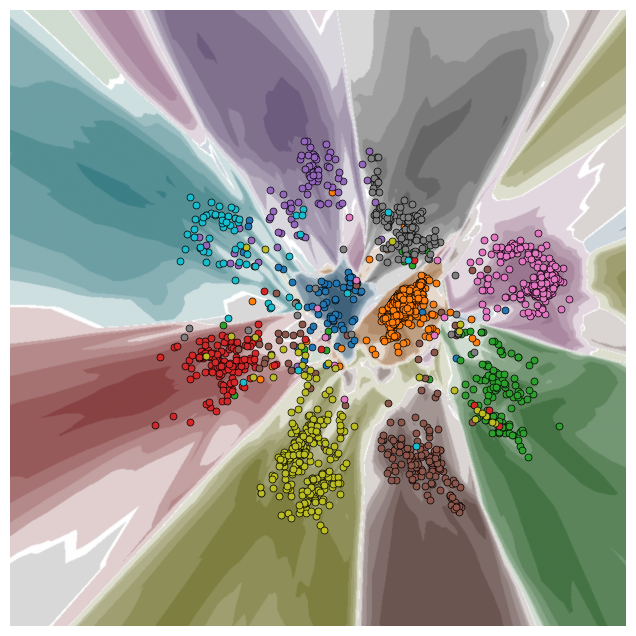

In [22]:
projector = VISProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='adjust_conf_vis', device=DEVICE)
# print('diff',diff[[[492, 783, 835, 871, 951, 1052,]]])

path = "/home/yifan/dataset/case_study_mnist_backdoor/clean_label.json"
with open(path, "r") as f:
    clean_label = json.load(f)
    
with open("/home/yifan/dataset/case_study_mnist_backdoor/noisy_label.json", "r") as f:
    noise_label = json.load(f)

noise_indicates = []
for i in range(len(clean_label)):
    if clean_label[i] != noise_label[i]:
        noise_indicates.append(i)

save_dir = os.path.join(data_provider.content_path, VIS_MODEL_NAME)
train_data = data_provider.train_representation(epoch)
labels = data_provider.train_labels(epoch)
train_data = train_data.reshape(train_data.shape[0],train_data.shape[1])
pred = data_provider.get_pred(epoch, train_data)
# pred = data_provider.get_pred(epoch,train_data)
new_pred_Res = pred.argmax(axis=1)
emb = projector.batch_project(epoch,train_data)
indicates = noise_indicates
print(indicates)
indicates = [492, 783, 835, 871, 951, 1052,]

sort_preds = np.sort(pred, axis=1)
diff = (sort_preds[:, -1] - sort_preds[:, -2]) / (sort_preds[:, -1] - sort_preds[:, 0])

inv = projector.batch_inverse(epoch, emb)
inv_pred = data_provider.get_pred(epoch, inv)
inv_sort_preds = np.sort(inv_pred, axis=1)
inv_diff = (inv_sort_preds[:, -1] - inv_sort_preds[:, -2]) / (inv_sort_preds[:, -1] - inv_sort_preds[:, 0])
# conf_error = []
# for i in range(len(diff)):
#     if abs(diff[i] - inv_diff[i]) > 0.3:
#         conf_error.append(i)
print("conf_error number:", len(conf_error))
from singleVis.visualizer import visualizer
now = time.strftime("%Y-%m-%d-%H_%M_%S", time.localtime(time.time())) 
from singleVis.eval.evaluate import *
val = evaluate_proj_nn_perseverance_knn(train_data, emb, n_neighbors=15, metric="euclidean")
print("nn",val)
vis = visualizer(data_provider, projector, 800, "tab10")
vis.savefig_custom(epoch, path=os.path.join(save_dir, "{}_{}_{}_{}.png".format(DATASET, epoch, VIS_METHOD,now)),
            pred=new_pred_Res[conf_error],
            train_labels=new_pred_Res[conf_error], 
            embedding=emb[conf_error])

In [14]:
val

1.41875

In [10]:
k=0
for i in range(len(conf_error)):
    index = conf_error[i]
    if abs(diff[index]-inv_diff[index]) > 0.3:
        k=k+1
print("current error:{}/{}".format(k,len(conf_error)))

current error:1426/3677


In [11]:
k=0
for i in range(len(train_data)):
    if abs(diff[i]-inv_diff[i]) > 0.3:
        k=k+1
print("total conf error:{}/{}".format(k,len(train_data)))

total conf error:1458/60000


In [12]:
k=0
inv_pred_Res = inv_pred.argmax(axis=1)
for i in range(len(inv_pred_Res)):
    if inv_pred_Res[i] != new_pred_Res[i]:
        k=k+1
k

295